<h1>TP Deep Learning - Interprétabilité</h1>

* Visualisation des filtres par maximisation des activations sur VGG16 pré-entrainé
* Class Activation Map (CAM) sur ResNet50
* Une toolbox à découvrir: tf-explain

<hr/>

Import des premiers packages nécessaires :

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization
import cv2     
print(keras.__version__, cv)

2.10.0


In [2]:
device = tf.config.experimental.list_physical_devices('GPU')
tf.config.set_visible_devices(device[0], 'GPU')
device

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

<h3>Chargement de VGG16</h3>

On charge un modèle pré-entrainé sur ImageNet et affiche l'architecture.


In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import json

# chargement du modèle complet VGG16
model3 = VGG16(include_top=True, weights='imagenet')
print(model3.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

<br/>
<hr/>
<h3> Visualisation par maximisation d'activations</h3>
  
Cette méthodes consiste à optimiser une fonction des activations d'une carte de convolution en fonction des entrées (images) du réseau. Maximiser cette fonction en suivant le gradient de la sortie par rapport aux entrées, revient à déterminer une image (artificielle) dont VGG16 obtient une forte réponse à la convolution du filtre ciblé. L'image produite va être composée du "pattern" reconnu par le filtre...

D'abord, des fonctions utiles :

In [4]:
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display

def show_images(images, cols = 1):
    n_images = len(images)
    fig = plt.figure()
    for n, image in enumerate(images):
        a = fig.add_subplot(cols, int(np.ceil(n_images/float(cols))), n + 1)
        plt.axis('off')
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x = np.array(x, dtype=np.float64)

    x -= x.mean()
    x /= (x.std() + 1e-5) # K.epsilon())
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255

    return x.astype(np.uint8)

Maximisation par gradient ascent.

226470.45


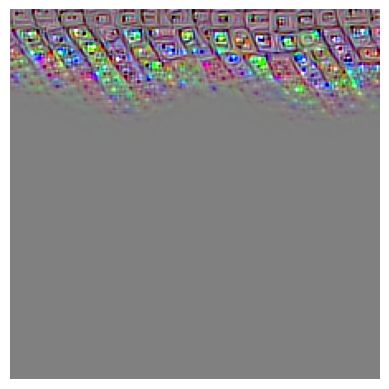

In [5]:
# Choisir une couche et numéro de filtre à visualiser
num_layer = 12 #3#18
num_filter = 30 #42#498 #500,30,100

# Définit un submodel de l'entrée vers la couche visée
submodel = tf.keras.models.Model([model3.inputs[0]], [model3.layers[num_layer].output])

# Initialise une image aléatoire et cast en variable tf.float32
input_img_data = np.random.random((1, 224, 224, 3))
input_img_data = tf.Variable(tf.cast(input_img_data, tf.float32))

# Iterate gradient ascents
epochs = 500
step_size = 10.
for i in range(epochs):
    with tf.GradientTape() as tape:
        outputs = submodel(input_img_data)
        loss_value = tf.reduce_mean(outputs[:, :, :, num_filter])
    grads = tape.gradient(loss_value, input_img_data) # gradient of loss wrt inputs
    normalized_grads = grads / (tf.sqrt(tf.reduce_mean(tf.square(grads))) + 1e-5)
    input_img_data.assign_add(normalized_grads * step_size)

# Affichage de l'image obtenue
print(loss_value.numpy())
img = deprocess_image(input_img_data)
show_images(img)

<b> A faire : </b> variez les couches et les filtres, puis commentez vos résultats. Comment obtenir des motifs encore plus complexes ? Pourquoi ?
<br/>


-> En faisant varier le nombre de filtres (10 puis 60) on remarque que l'image en sorti devient presque totalement bruité, de plus les motifs disparaissent. <br>
-> En gardant une valeur de filtre proche de 30 et en prennant moins de couche dense (une dizaine), on observe une augmentation des motifs. <br>
-> Pour obtenir des motifs plus complexe, il faut pour cela augmenter le nombre de filtre progressivement et faire varier le nombre de layer en parallèle. 


## CAM from scratch (avec Resnet)

Cette partie montre une implémentation simple de CAM sur ResNet

1/1 [==============================] - 1s 536ms/step
(49, 2048)
(224, 224, 3)


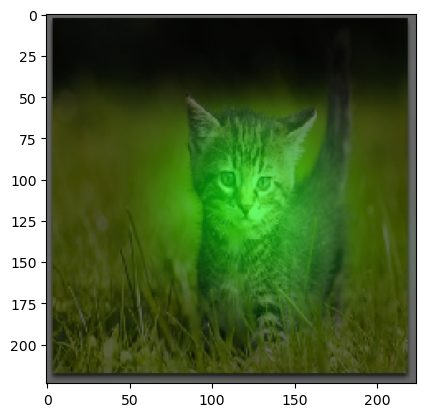

In [6]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model
import matplotlib.cm as cm

# Récupération du modèle complet
model4 = ResNet50(include_top=True, weights='imagenet')
#print(model4.summary())

img_path = 'cat.jpg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# prediction and and make one hot vector for predicted class
softmax_output = model4.predict(x)
best_class = np.argmax(softmax_output)
y = np.zeros(shape=softmax_output.shape)
y[0,best_class] = 1

# make a subnetwork from input to the last conv layer
model5 = Model(model4.inputs, model4.layers[-3].output)

# get feature maps for and flatten spatial dims
features = model5.predict(x).reshape((49,2048))
print(features.shape)

# get weights of last (dense) layer
weights = model4.layers[-1].get_weights()[0]

# compute and reshape saliency map
map = np.dot(features, weights[:, best_class]).reshape((7,7))

# normalization and co for visualization
map = (map - np.min(map))/(np.max(map)-np.min(map))
map = np.array([map*0, map, map*0])
map = np.clip(map, 0, 1)
map = map * 255
map = np.rollaxis(map, 0, 3)

# make a combined image with original and map
img2 = Image.fromarray(map.astype('uint8'))
img2 = img2.resize(img.size) # resize saliency map from 7x7 to origin image size
data = np.array(img2).astype('float64') * 0.6 + np.array(img).astype('float64') * 0.4
print(data.shape)
img3 = Image.fromarray(data.astype('uint8'))
plt.imshow(img3)

## CAM & co with toolbox

On utilise le package tf-explain: https://github.com/sicara/tf-explain

In [10]:
import tf_explain
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'tf_explain'

modification du code de la lib en changeant output_shape vers output.shape :)

In [ ]:
"""
Core Module for Grad CAM Algorithm
"""
import numpy as np
import tensorflow as tf
import cv2

from tf_explain.utils.display import grid_display, heatmap_display
from tf_explain.utils.saver import save_rgb


class GradCAM:

    """
    Perform Grad CAM algorithm for a given input

    Paper: [Grad-CAM: Visual Explanations from Deep Networks
            via Gradient-based Localization](https://arxiv.org/abs/1610.02391)
    """

    def explain(
        self,
        validation_data,
        model,
        class_index,
        layer_name=None,
        use_guided_grads=True,
        colormap=cv2.COLORMAP_VIRIDIS,
        image_weight=0.7,
    ):
        """
        Compute GradCAM for a specific class index.

        Args:
            validation_data (Tuple[np.ndarray, Optional[np.ndarray]]): Validation data
                to perform the method on. Tuple containing (x, y).
            model (tf.keras.Model): tf.keras model to inspect
            class_index (int): Index of targeted class
            layer_name (str): Targeted layer for GradCAM. If no layer is provided, it is
                automatically infered from the model architecture.
            colormap (int): OpenCV Colormap to use for heatmap visualization
            image_weight (float): An optional `float` value in range [0,1] indicating the weight of
                the input image to be overlaying the calculated attribution maps. Defaults to `0.7`.
            use_guided_grads (boolean): Whether to use guided grads or raw gradients

        Returns:
            numpy.ndarray: Grid of all the GradCAM
        """
        images, _ = validation_data

        if layer_name is None:
            layer_name = self.infer_grad_cam_target_layer(model)

        outputs, grads = GradCAM.get_gradients_and_filters(
            model, images, layer_name, class_index, use_guided_grads
        )

        cams = GradCAM.generate_ponderated_output(outputs, grads)

        heatmaps = np.array(
            [
                # not showing the actual image if image_weight=0
                heatmap_display(cam.numpy(), image, colormap, image_weight)
                for cam, image in zip(cams, images)
            ]
        )

        grid = grid_display(heatmaps)

        return grid

    @staticmethod
    def infer_grad_cam_target_layer(model):
        """
        Search for the last convolutional layer to perform Grad CAM, as stated
        in the original paper.

        Args:
            model (tf.keras.Model): tf.keras model to inspect

        Returns:
            str: Name of the target layer
        """
        for layer in reversed(model.layers):
            # Select closest 4D layer to the end of the network.
            if len(layer.output.shape) == 4:
                return layer.name

        raise ValueError(
            "Model does not seem to contain 4D layer. Grad CAM cannot be applied."
        )

    @staticmethod
    def get_gradients_and_filters(
        model, images, layer_name, class_index, use_guided_grads
    ):
        """
        Generate guided gradients and convolutional outputs with an inference.

        Args:
            model (tf.keras.Model): tf.keras model to inspect
            images (numpy.ndarray): 4D-Tensor with shape (batch_size, H, W, 3)
            layer_name (str): Targeted layer for GradCAM
            class_index (int): Index of targeted class
            use_guided_grads (boolean): Whether to use guided grads or raw gradients

        Returns:
            Tuple[tf.Tensor, tf.Tensor]: (Target layer outputs, Guided gradients)
        """
        grad_model = tf.keras.models.Model(
            [model.inputs], [model.get_layer(layer_name).output, model.output]
        )

        with tf.GradientTape() as tape:
            inputs = tf.cast(images, tf.float32)
            tape.watch(inputs)
            conv_outputs, predictions = grad_model(inputs)
            loss = predictions[:, class_index]

        grads = tape.gradient(loss, conv_outputs)

        if use_guided_grads:
            grads = (
                tf.cast(conv_outputs > 0, "float32")
                * tf.cast(grads > 0, "float32")
                * grads
            )

        return conv_outputs, grads

    @staticmethod
    def generate_ponderated_output(outputs, grads):
        """
        Apply Grad CAM algorithm scheme.

        Inputs are the convolutional outputs (shape WxHxN) and gradients (shape WxHxN).
        From there:
            - we compute the spatial average of the gradients
            - we build a ponderated sum of the convolutional outputs based on those averaged weights

        Args:
            output (tf.Tensor): Target layer outputs, with shape (batch_size, Hl, Wl, Nf),
                where Hl and Wl are the target layer output height and width, and Nf the
                number of filters.
            grads (tf.Tensor): Guided gradients with shape (batch_size, Hl, Wl, Nf)

        Returns:
            List[tf.Tensor]: List of ponderated output of shape (batch_size, Hl, Wl, 1)
        """

        maps = [
            GradCAM.ponderate_output(output, grad)
            for output, grad in zip(outputs, grads)
        ]

        return maps

    @staticmethod
    def ponderate_output(output, grad):
        """
        Perform the ponderation of filters output with respect to average of gradients values.

        Args:
            output (tf.Tensor): Target layer outputs, with shape (Hl, Wl, Nf),
                where Hl and Wl are the target layer output height and width, and Nf the
                number of filters.
            grads (tf.Tensor): Guided gradients with shape (Hl, Wl, Nf)

        Returns:
            tf.Tensor: Ponderated output of shape (Hl, Wl, 1)
        """
        weights = tf.reduce_mean(grad, axis=(0, 1))

        # Perform ponderated sum : w_i * output[:, :, i]
        cam = tf.reduce_sum(tf.multiply(weights, output), axis=-1)

        return cam

    def save(self, grid, output_dir, output_name):
        """
        Save the output to a specific dir.

        Args:
            grid (numpy.ndarray): Grid of all the heatmaps
            output_dir (str): Output directory path
            output_name (str): Output name
        """
        save_rgb(grid, output_dir, output_name)

Chargement d'une image dont on veut visualiser la prédiction et utilisation de tf-explain

In [ ]:

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
img = tf.keras.preprocessing.image.img_to_array(img)

data = ([img], None)

tabby_cat_class_index = 281 # or use network's prediction!

explainer = GradCAM()
# Compute GradCAM on VGG16
output = explainer.explain(data, model4, class_index=tabby_cat_class_index)#, layer_name="block5_conv3")
plt.imshow(output)



**A Faire:** (1) modifiez le code ci-dessus pour utiliser la prédiction du réseaux plutot que 281. (2) explorez tf-explain et testez d'autres méthodes